# Net-Flow Analysis for CitiBike (2023–2025)

This notebook analyzes station-level **net flow**, defined as departures minus arrivals, to:
- identify structurally imbalanced stations,
- understand temporal patterns in net flow, and
- build a predictive model to support rebalancing operations.

In [1]:
# Imports
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from meteostat import Point, Daily

DATA_PATH = "../data/processed/citibike/*/*/data.parquet"

con = duckdb.connect(database=":memory:")

query = f"""
WITH departures AS (
    SELECT
        start_station_id AS station_id,
        date_trunc('day', started_at) AS date,
        COUNT(*) AS departures
    FROM read_parquet('{DATA_PATH}')
    WHERE start_station_id IS NOT NULL
    GROUP BY 1,2
),
arrivals AS (
    SELECT
        end_station_id AS station_id,
        date_trunc('day', ended_at) AS date,
        COUNT(*) AS arrivals
    FROM read_parquet('{DATA_PATH}')
    WHERE end_station_id IS NOT NULL
    GROUP BY 1,2
),
combined AS (
    SELECT
        COALESCE(d.station_id, a.station_id) AS station_id,
        COALESCE(d.date, a.date) AS date,
        COALESCE(d.departures, 0) AS departures,
        COALESCE(a.arrivals, 0) AS arrivals
    FROM departures d
    FULL OUTER JOIN arrivals a
    ON d.station_id = a.station_id
       AND d.date = a.date
),

-- Reconstruct station metadata from both start_* and end_* columns
st_meta AS (
    WITH starts AS (
        SELECT DISTINCT
            start_station_id AS station_id,
            start_lat AS lat,
            start_lng AS lng
        FROM read_parquet('{DATA_PATH}')
        WHERE start_station_id IS NOT NULL
    ),
    ends AS (
        SELECT DISTINCT
            end_station_id AS station_id,
            end_lat AS lat,
            end_lng AS lng
        FROM read_parquet('{DATA_PATH}')
        WHERE end_station_id IS NOT NULL
    ),
    unioned AS (
        SELECT * FROM starts
        UNION ALL
        SELECT * FROM ends
    )
    SELECT
        station_id,
        AVG(lat) AS lat,
        AVG(lng) AS lng
    FROM unioned
    GROUP BY station_id
)

-- Final join: net_flow + station coordinates
SELECT
    c.station_id,
    c.date,
    c.departures,
    c.arrivals,
    c.arrivals - c.departures AS net_flow,
    s.lat,
    s.lng
FROM combined c
LEFT JOIN st_meta s
    ON c.station_id = s.station_id
ORDER BY c.station_id, c.date
"""
net_daily = con.execute(query).df()


## Descriptive Analysis of Net Flow

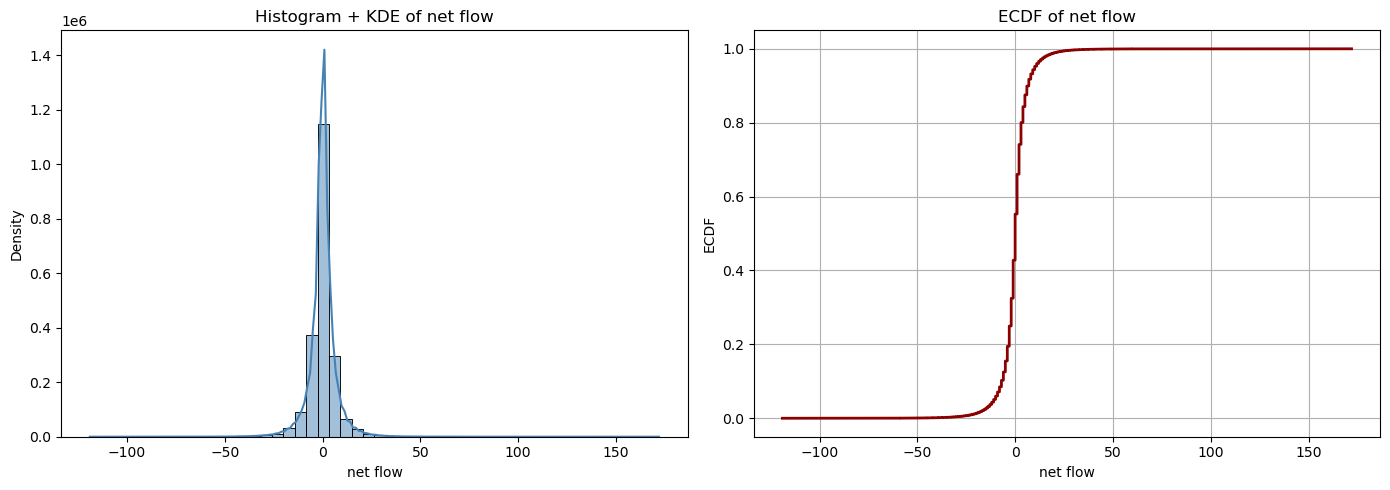

In [2]:
import seaborn as sns
# Visualize the distribution of risk_norm
vals = net_daily["net_flow"].values


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --------------------------------------------
# LEFT: Histogram + KDE
# --------------------------------------------
sns.histplot(vals, bins=50, kde=True, ax=axes[0], color="steelblue")
axes[0].set_xlabel("net flow")
axes[0].set_ylabel("Density")
axes[0].set_title("Histogram + KDE of net flow")

# --------------------------------------------
# RIGHT: ECDF
# --------------------------------------------
sorted_vals = np.sort(vals)
ecdf = np.linspace(0, 1, len(sorted_vals))

axes[1].plot(sorted_vals, ecdf, color="darkred", lw=2)
axes[1].set_xlabel("net flow")
axes[1].set_ylabel("ECDF")
axes[1].set_title("ECDF of net flow")
axes[1].grid(True)

fig.tight_layout()
fig.savefig("../src/figures/net_flow_distribution.png", dpi=300)
plt.show()

The distribution of station-level net flow is concentrated around zero: about 80% of all station-days fall between −5 and +5, with only thin but important tails representing larger imbalances. This pattern implies that predicting the exact net-flow value is neither meaningful nor useful as most variation near zero is operationally irrelevant, while the rare extreme values are precisely where rebalancing matters.

A continuous regression model would therefore focus on minimizing error in the dense central region, where prediction is least important, and fail to capture the operationally critical tail events that lead to stations becoming empty or full.

For this reason, it is more appropriate to convert the problem into a ternary classification task based on simple operational thresholds:

Exporter (net flow < −5): station likely to run empty

Balanced (−5 ≤ net flow ≤ +5): no intervention needed

Importer (net flow > +5): station likely to fill up

This framing aligns the prediction problem directly with rebalancing needs by highlighting only those imbalances that matter operationally.

## 4. Spatial Patterns of Net Flow (Maps)


In [3]:
import folium

#Average net flow per station across the whole period
station_avg_net = (
    net_daily
    .groupby("station_id", as_index=False)
    .agg(
        avg_net_flow=("net_flow", "mean"),
        lat=("lat", "mean"),   # or "first" – they should be identical per station
        lng=("lng", "mean"),
    )
)

# 3.3 Identify top exporters/importers
n_top = 20
top_exporters = station_avg_net.nlargest(n_top, "avg_net_flow")
top_importers = station_avg_net.nsmallest(n_top, "avg_net_flow")

# Center roughly on Manhattan
m = folium.Map(location=[40.75, -73.97], zoom_start=12)

for _, row in pd.concat([top_exporters, top_importers]).dropna(subset=["lat", "lng"]).iterrows():
    color = "blue" if row["avg_net_flow"] < 0 else "red"
    folium.CircleMarker(
        location=[row["lat"], row["lng"]],
        radius=4,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=f"Station {row['station_id']}: {row['avg_net_flow']:.2f}",
    ).add_to(m)

m.save("station_avg_net_flow_map.html")


## Predicting Imbalance

### Feature Engineering

To predict whether a station will experience a meaningful imbalance (importer, balanced, or exporter) on the next day, we construct a set of features that capture the temporal dynamics, seasonal patterns, spatial structure, and weather-related drivers of CitiBike usage. Each feature is chosen because it encodes information known at prediction time and has clear relevance from both a behavioral and operational standpoint.

#### Lagged net-flow features (lag1, lag7).
Net flow displays strong temporal autocorrelation: stations that exported or imported bikes today are more likely to do so tomorrow. The one-day lag captures short-run momentum, while the seven-day lag captures stable weekly patterns driven by commuting cycles and neighborhood routines.

#### Rolling mean of past three days.
Short-run trends in demand—such as sustained increases in commuter usage or gradual shifts caused by local events—are better captured by smoothing recent net-flow values. This rolling average reduces noise around zero and provides a clearer indication of whether a station is trending toward becoming an importer or exporter.

#### Day-of-week (weekday).
Bike usage varies systematically across the week, with strong commuter peaks on weekdays and different travel patterns on weekends. Encoding the day-of-week helps the model learn these regular temporal rhythms.

#### Month.
Monthly variation captures seasonality in cycling behavior. Usage generally increases in warmer months and decreases in winter, affecting both overall demand and the likelihood of directional imbalances at individual stations.

#### Latitude and longitude.
Spatial location is a key determinant of station behavior. Stations near transit hubs, business districts, residential neighborhoods, parks, or waterfronts exhibit distinct flow patterns. Including coordinates allows the model to exploit these structural spatial differences without requiring explicit neighborhood labels.

#### Lagged weather features (temperature, rain, snow).
Weather is one of the strongest predictors of cycling activity. However, to avoid using future information, we include only lagged weather values (e.g., yesterday’s temperature or precipitation), which influence short-run cycling behavior and preserve causal validity. These variables help capture inertia in demand and make the model sensitive to weather-driven shifts without introducing data leakage.

Together, these features encode the temporal, spatial, and environmental determinants of CitiBike imbalance in a way that is predictive, interpretable, and operationally meaningful.

In [4]:
# Weather data integration
# 1. Define NYC center point (roughly Manhattan)
nyc = Point(40.75, -73.97)

# 2. Define date range
start = datetime(2023, 1, 1)
end   = datetime(2025, 10, 31)   # adjust to your data

# 3. Fetch daily data
daily = Daily(nyc, start, end)
weather = daily.fetch()  # returns a pandas DataFrame indexed by date

# 4. Prepare DataFrame
weather_daily = (
    weather
    .reset_index()
    .rename(columns={
        "time": "date",
        "tavg": "temp",
        "prcp": "rain",
        "snow": "snow"
    })
)

weather_daily["date"] = pd.to_datetime(weather_daily["date"])
weather_daily = weather_daily[["date", "temp", "rain", "snow"]]

net_daily["date"] = pd.to_datetime(net_daily["date"])

# Merge weather
df = net_daily.merge(weather_daily, on="date", how="left")
df = df.sort_values(["station_id", "date"]).reset_index(drop=True)

# Lagged weather features
df["temp_lag1"] = df["temp"].shift(1)
df["rain_lag1"] = df["rain"].shift(1)
df["snow_lag1"] = df["snow"].shift(1)

# Lagged net flow
df["lag1_net_flow"] = df.groupby("station_id")["net_flow"].shift(1)
df["lag7_net_flow"] = df.groupby("station_id")["net_flow"].shift(7)

# Rolling mean
df["roll_mean_3"] = (
    df.groupby("station_id")["net_flow"]
      .shift(1)
      .rolling(3)
      .mean()
)

# Calendar features
df["dow"] = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month

# Target
def classify(x):
    if x < -5:
        return "exporter"
    elif x > 5:
        return "importer"
    else:
        return "balanced"

df["target"] = df["net_flow"].apply(classify)

feature_cols = [
    "lag1_net_flow", "lag7_net_flow", "roll_mean_3",
    "dow", "month", "lat", "lng",
    "temp_lag1", "rain_lag1", "snow_lag1",
]

df_model = df.dropna(subset=feature_cols + ["target"]).reset_index(drop=True)

In [5]:
df_model.head()

,station_id,date,departures,arrivals,net_flow,lat,lng,temp,rain,snow,temp_lag1,rain_lag1,snow_lag1,lag1_net_flow,lag7_net_flow,roll_mean_3,dow,month,target
0,1234.56,2025-06-25,12,6,-6,40.708948,-73.932777,31.3,0.1,0.0,32.5,0.0,0.0,1.0,1.0,1.666667,2,6,exporter
1,1234.56,2025-07-02,2,1,-1,40.708948,-73.932777,24.5,0.2,0.0,31.3,0.1,0.0,-6.0,-1.0,-0.666667,2,7,balanced
2,1234.56,2025-07-03,3,2,-1,40.708948,-73.932777,25.7,0.7,0.0,24.5,0.2,0.0,-1.0,0.0,-2.000000,3,7,balanced
3,1234.56,2025-07-04,4,11,7,40.708948,-73.932777,23.6,0.0,0.0,25.7,0.7,0.0,-1.0,5.0,-2.666667,4,7,importer
4,1234.56,2025-07-05,13,11,-2,40.708948,-73.932777,24.7,0.0,0.0,23.6,0.0,0.0,7.0,1.0,1.666667,5,7,balanced
